In [26]:
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Objectives

This notebook will cover data cleaning and explanatory data analysis. We have our data from the previous notebook which has FPS games each having the thread and post counts from unknowncheats as well as their wikipedia entry and anticheat system. 

For data cleaning, we will:

* perform general cleaning
* identify variables of interest

For EDA we will:

* look at distribution of variables in data
* identify outliers
* address small data size

We then export the cleaned data

first we read in the data from 1_data_collection notebook:

In [27]:
uc_games_df_joined = pd.read_pickle('../data/uc_games_df_joined')

### General Data Cleaning

We first do general data cleaning such as defining datatypes and aligning the case-sensitivities of strings.

In [28]:
# look at data
uc_games_df_joined.head(2)

,game_name,uc_game_link,uc_threads,uc_posts,wiki_content,software,developer,publisher
0,arma series,https://www.unknowncheats.me/forum/arma-series...,"5,970","91,647",Arma (sometimes stylised as ARMA) is a series ...,BattlEye,Bohemia Interactive,Bohemia Interactive
1,all points bulletin,https://www.unknowncheats.me/forum/all-points-...,"1,362","27,077",APB: All Points Bulletin is an open world mult...,BattlEye,Little Orbit,Little Orbit


In [29]:
# examine datatypes
uc_games_df_joined.dtypes.to_frame().rename(columns={0: 'dtype'})

,dtype
game_name,object
uc_game_link,object
uc_threads,object
uc_posts,object
wiki_content,object
software,object
developer,object
publisher,object


#### Change the datatypes

In [30]:
# post and thread counts should be numeric
uc_games_df_joined['uc_threads'] = uc_games_df_joined['uc_threads'].str.replace(',', '').astype('int')
uc_games_df_joined['uc_posts'] = uc_games_df_joined['uc_posts'].str.replace(',', '').astype('int')

# all other columns should be left as object as they are strings

#### Check null counts

In [31]:
uc_games_df_joined.isnull().sum().to_frame().rename(columns={0: 'null_count'})

,null_count
game_name,0
uc_game_link,0
uc_threads,0
uc_posts,0
wiki_content,0
software,0
developer,0
publisher,0


There are no nulls (which we made sure to do in 1_data_collection notebook)

#### General cleaning for strings

We will change all the strings except the game_name to lower case and remove irregular characters (we leave game_name untouched to keep it consistent with the raw data from unknowncheats)

In [32]:
# software, developer, publisher

# make lowercase
for col in ['software', 'developer', 'publisher']:
    uc_games_df_joined[col] = uc_games_df_joined[col].str.lower()
    
# besides for the case, we want to preserve the characters in these columns as is because they are names of companies/software

In [33]:
# wiki_content

# make lowercase
uc_games_df_joined['wiki_content'] = uc_games_df_joined['wiki_content'].str.lower()

# removing urls
uc_games_df_joined['wiki_content'] = uc_games_df_joined['wiki_content'].apply(lambda x: re.sub(r'http\S+', '', x))
# removing irregular characters
uc_games_df_joined['wiki_content'] = uc_games_df_joined['wiki_content'].apply(lambda x: re.sub('[^a-zA-Z0-9 \n]', '', x))
# replacing the line breaks with spaces
uc_games_df_joined['wiki_content'] = uc_games_df_joined['wiki_content'].apply(lambda x: re.sub('[\n]', ' ', x))
# remove multiple spaces with just one space
uc_games_df_joined['wiki_content'] = uc_games_df_joined['wiki_content'].apply(lambda x: re.sub(' +', ' ', x))
# # removing all numbers and numerics
uc_games_df_joined['wiki_content'].replace('\d+', '', regex=True, inplace=True)

sources for text cleaning:
* https://gist.github.com/MrEliptik/b3f16179aa2f530781ef8ca9a16499af
* https://stackoverflow.com/questions/23996118/replace-special-characters-in-a-string-in-python
* https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string

### Cleaning based on number of games in series

There is an inbalance that exists in the data because some of the games are series which contain more than one game (therefore increasing the post/thread count for the game). We therefore divide the number of posts/threads by the number of games which occur in each series. The remaining series will be representative of an average game in the series.

Note that the number of games in each series is pulled from the wikipedia article for each series. Expansion packs, downloadable content, and add-ons to games are not counted.

In [34]:
# create dictionary for number of games in each series
# unlisted games only have 1 game in the series
number_in_series = {'arma series': 6, 'america\'s army operations': 4, 'call of duty series': 21, 'crysis series': 3, 
                    'fear': 3, 'far cry': 6, 'halo': 6, 'medal of honor series': 14, 'overwatch': 2, 'quake series': 9, 
                    'rainbow six siege': 15, 'titanfall': 3, 'tom clancy\'s the division': 2}


In [35]:
# replace post and thread count by number of games in each series
uc_games_df_joined['uc_posts'] = uc_games_df_joined['uc_posts'] / uc_games_df_joined['game_name'].map(number_in_series).replace(np.nan, 1)
uc_games_df_joined['uc_threads'] = uc_games_df_joined['uc_threads'] / uc_games_df_joined['game_name'].map(number_in_series).replace(np.nan, 1)

In [36]:
# check to see that the division was applied properly
uc_games_df_joined.head(2)

,game_name,uc_game_link,uc_threads,uc_posts,wiki_content,software,developer,publisher
0,arma series,https://www.unknowncheats.me/forum/arma-series...,995.0,15274.5,arma sometimes stylised as arma is a series of...,battleye,bohemia interactive,bohemia interactive
1,all points bulletin,https://www.unknowncheats.me/forum/all-points-...,1362.0,27077.0,apb all points bulletin is an open world multi...,battleye,little orbit,little orbit


In [37]:
uc_games_df_joined.sort_values(by='uc_posts', ascending=False)

,game_name,uc_game_link,uc_threads,uc_posts,wiki_content,software,developer,publisher
8,counter strike,https://www.unknowncheats.me/forum/counter-str...,28290.000000,508197.000000,counterstrike cs is a series of multiplayer ta...,valve anti-cheat,valve,valve
5,battlefield series,https://www.unknowncheats.me/forum/battlefield...,9085.000000,191476.000000,battlefield is a series of firstperson shooter...,punkbuster,dice,electronic arts
21,playerunknown's battlegrounds,https://www.unknowncheats.me/forum/playerunkno...,5830.000000,109490.000000,pubg battlegrounds previously known as playeru...,battleye,pubg corporation,pubg corporation
4,apex legends,https://www.unknowncheats.me/forum/apex-legend...,1744.000000,51976.000000,apex legends is a freetoplay battle royalehero...,easy anti-cheat,respawn entertainment,electronic arts
25,rust,https://www.unknowncheats.me/forum/rust/?s=e67...,3311.000000,50855.000000,rust is a multiplayeronly survival video game ...,easy anti-cheat,facepunch studios,facepunch studios
19,payday 2,https://www.unknowncheats.me/forum/payday-2-a/...,3101.000000,48959.000000,payday is a cooperative firstperson shooter v...,none,overkill software,505 games
32,valorant,https://www.unknowncheats.me/forum/valorant/?s...,1810.000000,43537.000000,valorant is a freetoplay firstperson tactical ...,vanguard,riot games,riot games
34,warface,https://www.unknowncheats.me/forum/warface/?s=...,2075.000000,40914.000000,warface is a freetoplay online firstperson sho...,easy anti-cheat,crytek,my.com
11,escape from tarkov,https://www.unknowncheats.me/forum/escape-from...,1528.000000,33034.000000,escape from tarkov is a multiplayer tactical f...,battleye,battlestate games,battlestate games
1,all points bulletin,https://www.unknowncheats.me/forum/all-points-...,1362.000000,27077.000000,apb all points bulletin is an open world multi...,battleye,little orbit,little orbit


### Exploratory Data Analysis

Next we want to explore the data, using visualizations to help

#### Wiki content length

We create a variable to look at the length of our wikipedia content for each game

In [38]:
uc_games_df_joined['wiki_content_length'] = uc_games_df_joined['wiki_content'].apply(lambda x: len(x))

We would expect that wikipedia entries for game series would be longer than those for just one game - however, usually wikipedia has a different page for each game in a game series. We will therefore keep the wiki_content_length as is while keeping this in mind. The length will not be used as any input to modeling, simply for EDA.

In [39]:
# look at wiki_content_length
uc_games_df_joined.head(2)

,game_name,uc_game_link,uc_threads,uc_posts,wiki_content,software,developer,publisher,wiki_content_length
0,arma series,https://www.unknowncheats.me/forum/arma-series...,995.0,15274.5,arma sometimes stylised as arma is a series of...,battleye,bohemia interactive,bohemia interactive,3061
1,all points bulletin,https://www.unknowncheats.me/forum/all-points-...,1362.0,27077.0,apb all points bulletin is an open world multi...,battleye,little orbit,little orbit,10855


#### Determining our $y$ variable

We have two options for our $y$ target, which are uc_posts (number of posts from unknowncheats) or uc_threads (number of threads from unknowncheats). First we plot them against eachother and find the correlation to see their relationship.

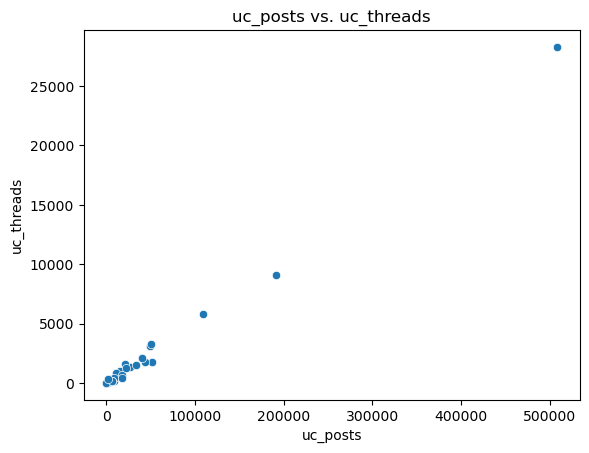

In [40]:
# create scatterplot of uc_posts versus uc_threads
sns.scatterplot(data=uc_games_df_joined, x="uc_posts", y="uc_threads")
# add title
plt.title('uc_posts vs. uc_threads')
# add axes labels
plt.xlabel('uc_posts')
plt.ylabel('uc_threads');

In [41]:
print(f"the correlation between uc_posts and uc_threads is \
{uc_games_df_joined['uc_posts'].corr(uc_games_df_joined['uc_threads']).round(2)}")

the correlation between uc_posts and uc_threads is 1.0


We see that the correlation is ~1, so we select the post count as our target as is has a larger range

#### Removing Outliers

We next look at outliers in the data by looking at the interquartile ranges

source: https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/

In [42]:
# define a function to find outliers
def iqr_method(df: pd.DataFrame, col: str):
    """
    finds outliers of df[col]
    """
    # define first quartile
    q1=df[col].quantile(0.25)
    # define third quartile
    q3=df[col].quantile(0.75)
    # define iqr as difference between first and third quartiles
    iqr = q3 - q1
    # identify outliers which fall 1.5 * iqr below q1 or 1.5 * iqr above q3
    return df.loc[(df[col]<(q1-1.5*iqr))|(df[col]>(q3+1.5*iqr))]

In [43]:
# look at outliers for uc_posts
iqr_method(df=uc_games_df_joined, col='uc_posts')

,game_name,uc_game_link,uc_threads,uc_posts,wiki_content,software,developer,publisher,wiki_content_length
5,battlefield series,https://www.unknowncheats.me/forum/battlefield...,9085.0,191476.0,battlefield is a series of firstperson shooter...,punkbuster,dice,electronic arts,9079
8,counter strike,https://www.unknowncheats.me/forum/counter-str...,28290.0,508197.0,counterstrike cs is a series of multiplayer ta...,valve anti-cheat,valve,valve,5979
21,playerunknown's battlegrounds,https://www.unknowncheats.me/forum/playerunkno...,5830.0,109490.0,pubg battlegrounds previously known as playeru...,battleye,pubg corporation,pubg corporation,51900


There are 3 outliers for uc_posts which have the uc_posts as above 100,000. We can see these games in our previous graph of uc_posts vs. uc_threads.
Usually we would remove these outliers, however we keep them for the following reasons:

1. Our dataset is incredibly small. If there were more samples, these may not be true outliers
2. We are very interested in these games. All three game series are notorious for the high amount of cheaters - they are actually the most interesting and relevent focal points of this project

We see below that there are no outliers for wiki_content length:

In [44]:
# look at outliers for wiki_content length
iqr_method(df=uc_games_df_joined, col='wiki_content_length')

,game_name,uc_game_link,uc_threads,uc_posts,wiki_content,software,developer,publisher,wiki_content_length


#### Wiki content length versus uc_posts

We look at wiki content length vs. uc_posts to see if there is a relationship:

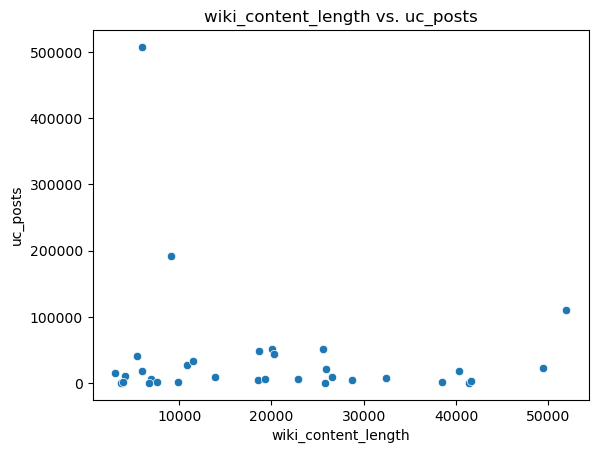

In [45]:
# create scatterplot of uc_posts versus uc_threads
sns.scatterplot(data=uc_games_df_joined, x="wiki_content_length", y="uc_posts")
# add title
plt.title('wiki_content_length vs. uc_posts')
# add axes labels
plt.xlabel('wiki_content_length')
plt.ylabel('uc_posts');

From the graph we can see that there is not a clear relationship between the two.

### Addressing the Data Size

By now it is clear that we have an extremely small dataset:

In [46]:
print(f'number of rows in data: {len(uc_games_df_joined)}')

number of rows in data: 35


It is not wise to create a model out of small datasets for many reasons. However, it is what we have just based on the fact that there are not thousands or millions of FPS games. We have the data we have.

How can we still gain valuable information from the data? How can we use this data quantitatively given its small size? I would like to focus on these questions in this project and use approaches to dealing with small data on our dataset.

There are several methods of dealing with small data, which are:
1. pre-processing
2. special purpose algorithm
3. post-processing
4. hybrid of the above

In particular, we will be focusing on methods of pre-processing to both gain insights from our very small data using modeling. We will then discuss warnings and model limitations to see if the results have meaning.

sources:

https://towardsdatascience.com/7-tips-for-dealing-with-small-data-7ffbd3d399a3

http://proceedings.mlr.press/v74/branco17a/branco17a.pdf

https://arxiv.org/pdf/1106.1813.pdf

https://researchcommons.waikato.ac.nz/bitstream/handle/10289/8518/smoteR.pdf;jsessionid=5C9737B851889537ED8F205E019C4053?sequence=23

### EDA Continued

We will now look at the anti-cheat software:

In [47]:
# examining the counts of anti-cheat software:
uc_games_df_joined.groupby('software')['game_name'].nunique().to_frame()

,game_name
software,
battleye,7
defense matrix,1
easy anti-cheat,8
equ8,1
fairfight,1
none,4
punkbuster,7
ricochet,1
valve anti-cheat,2


We can see there are several popular anti-cheat softwares which are used across many games.

Next we can examine the average post count ($y$) by software:

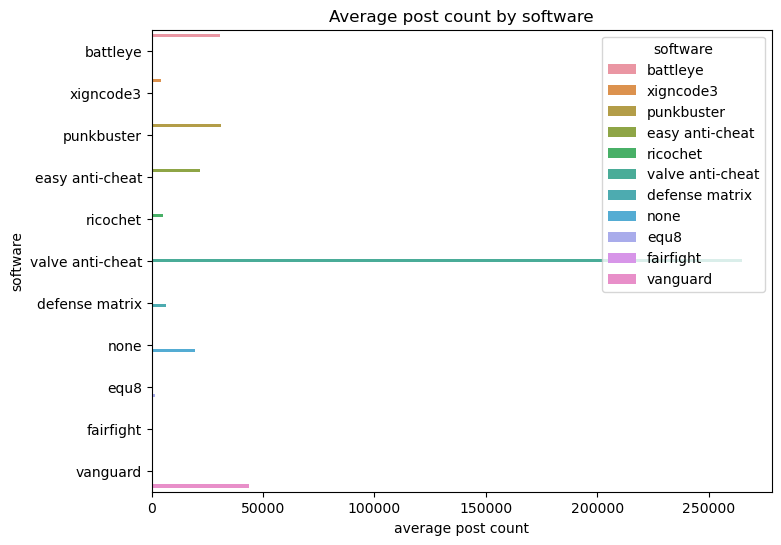

In [53]:
# Set the figure size
plt.figure(figsize=(8, 6))

# grouped barplot
ax = sns.barplot(
    y="software", 
    x="uc_posts", 
    hue="software", 
    data=uc_games_df_joined, 
    ci=None)

# Customize the axes and title
ax.set_title("Average post count by software")
ax.set_ylabel("software")
ax.set_xlabel("average post count");

# source: https://www.geeksforgeeks.org/grouped-barplots-in-python-with-seaborn/

It is hard to make conclusions on this based on the small data size, but we see that valve anti-cheat (n=2) has a much higher average post count than other anti-cheat software. The games which use this software are counter strike and team fortress 2 (the average is high due to counter strike alone).

In [49]:
uc_games_df_joined.loc[uc_games_df_joined['software']=='valve anti-cheat'][['game_name', 'uc_posts']]

,game_name,uc_posts
8,counter strike,508197.0
30,team fortress 2,22081.0


#### Distribution of $y$

Finally we plot the distribution of uc_posts:

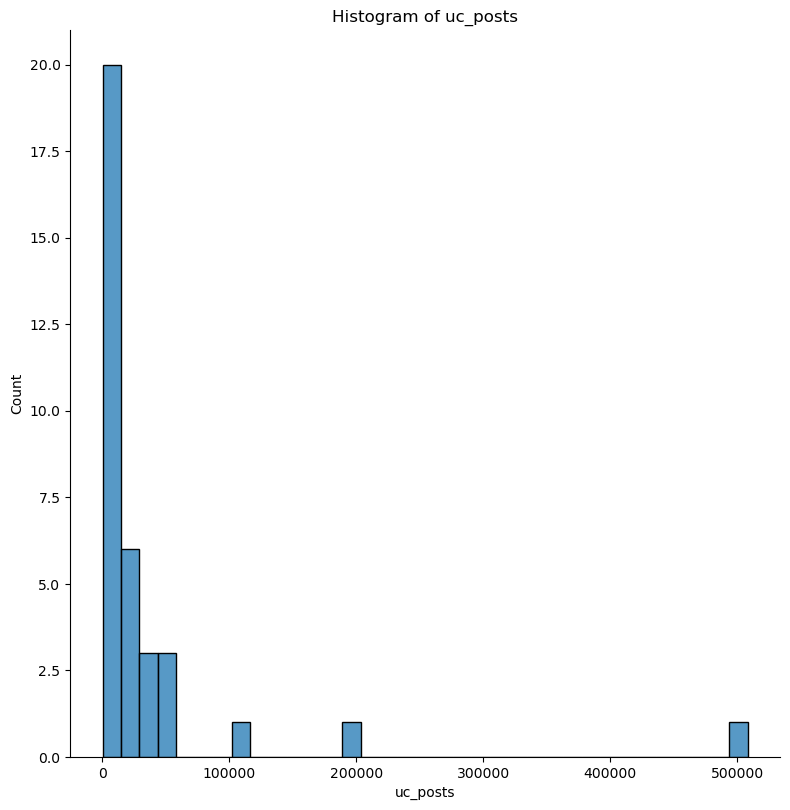

In [50]:
rel = sns.displot(uc_games_df_joined, x="uc_posts", bins=35, height=8)
rel.set(title='Histogram of uc_posts')

plt.show();

Again we can see the outliers with high uc_posts in our data.

#### Distribution of wiki_content_length

We look at the distribution of wiki_content_length below:

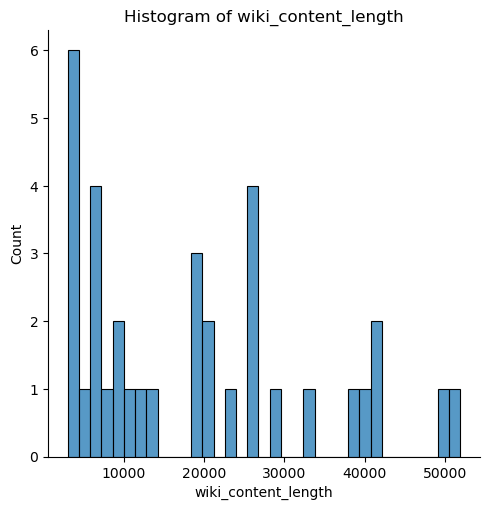

In [51]:
rel = sns.displot(uc_games_df_joined, x="wiki_content_length", bins=35)
rel.set(title='Histogram of wiki_content_length');

### Data Export

We export our cleaned data for modeling:

In [52]:
# save uc_games_df_joined to pickle
uc_games_df_joined.to_pickle('../data/uc_games_df_clean')